In [13]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [0]:
import pickle
import numpy as np

In [15]:
train_images = pickle.load(open("/gdrive/My Drive/Colab/data/image_train.p", "rb"))
print(train_images.shape)

(9983, 3, 80, 160)


In [16]:
labels = pickle.load(open("/gdrive/My Drive/Colab/data/mask_labels.p", "rb"))
print(labels.shape)

(9983, 1, 80, 160)


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [0]:
x_train = torch.FloatTensor(train_images)
y_train = torch.FloatTensor(labels)

In [0]:
dataset = TensorDataset(x_train, y_train)
train_set, val_set = torch.utils.data.random_split(dataset, [7983, 2000])

In [0]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=True)

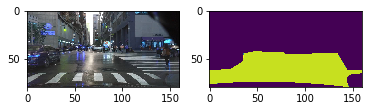

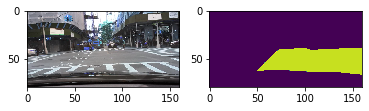

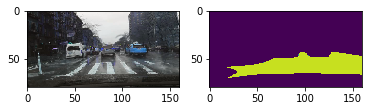

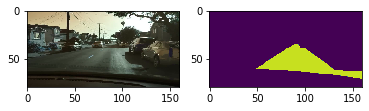

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

dataiter = iter(train_loader)
images, labels = dataiter.next()

show_img = (np.transpose(images, (0, 2, 3, 1))).numpy()
show_label = (np.transpose(labels, (0, 2, 3, 1))).numpy()

for i in range(4):
    fig = plt.figure()
    
    npimg = show_img[i]
    nplabel = show_label[i]
    nplabel = nplabel.squeeze()
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(npimg)
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(nplabel)
    plt.show()

In [22]:
import torch.nn as nn
import torch.nn.functional as F


net = torch.nn.Sequential(
    torch.nn.Conv2d(3, 8, 3, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(8, 16, 3, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, 2),

    torch.nn.Conv2d(16, 16, 3, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(16, 32, 3, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(32, 32, 3, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, 2),

    torch.nn.Conv2d(32, 64, 3, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(64, 64, 3, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, 2),

    torch.nn.Upsample(scale_factor=2),
    torch.nn.Conv2d(64, 64, 3, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(64, 32, 3, padding=1),
    torch.nn.ReLU(),
    
    torch.nn.Upsample(scale_factor=2),
    torch.nn.Conv2d(32, 32, 3, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(32, 16, 3, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(16, 16, 3, padding=1),
    torch.nn.ReLU(),
    
    torch.nn.Upsample(scale_factor=2),
    torch.nn.Conv2d(16, 8, 3, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(8, 1, 3, padding=1),
    torch.nn.ReLU(),
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

cuda:0


Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU()
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Upsample(scale_factor=2.0, mode=nearest)
  (18): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (19)

In [0]:
import torch.optim as optim

criterion = nn.MSELoss()

learning_rate = 0.0005
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [24]:
train_losses, val_losses, accuracy = [], [], []
epochs = 30

for epoch in range(epochs):
    running_loss = 0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    else:
        val_loss = 0
        val_accuracy = 0
        
        with torch.no_grad():
            cnt = 0
            
            for val_image, val_label in val_loader:
                val_image, val_label = val_image.to(device), val_label.to(device)
                val_outputs = net(val_image)
                
                val_loss += criterion(val_outputs, val_label)
        
        train_losses.append(running_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))

        print("Epoch: {}/{} || ".format(epoch+1, epochs),
              "Training Loss: {:.5f} || ".format(running_loss/len(train_loader)),
              "Val Loss: {:.5f} ".format(val_loss/len(val_loader))
             )

print('Finished Training')

Epoch: 1/30 ||  Training Loss: 0.00796 ||  Val Loss: 0.00657 
Epoch: 2/30 ||  Training Loss: 0.00597 ||  Val Loss: 0.00602 
Epoch: 3/30 ||  Training Loss: 0.00557 ||  Val Loss: 0.00548 
Epoch: 4/30 ||  Training Loss: 0.00532 ||  Val Loss: 0.00515 
Epoch: 5/30 ||  Training Loss: 0.00504 ||  Val Loss: 0.00491 
Epoch: 6/30 ||  Training Loss: 0.00481 ||  Val Loss: 0.00468 
Epoch: 7/30 ||  Training Loss: 0.00454 ||  Val Loss: 0.00445 
Epoch: 8/30 ||  Training Loss: 0.00436 ||  Val Loss: 0.00437 
Epoch: 9/30 ||  Training Loss: 0.00418 ||  Val Loss: 0.00420 
Epoch: 10/30 ||  Training Loss: 0.00403 ||  Val Loss: 0.00409 
Epoch: 11/30 ||  Training Loss: 0.00396 ||  Val Loss: 0.00410 
Epoch: 12/30 ||  Training Loss: 0.00386 ||  Val Loss: 0.00404 
Epoch: 13/30 ||  Training Loss: 0.00383 ||  Val Loss: 0.00393 
Epoch: 14/30 ||  Training Loss: 0.00371 ||  Val Loss: 0.00390 
Epoch: 15/30 ||  Training Loss: 0.00365 ||  Val Loss: 0.00379 
Epoch: 16/30 ||  Training Loss: 0.00362 ||  Val Loss: 0.00374 
E

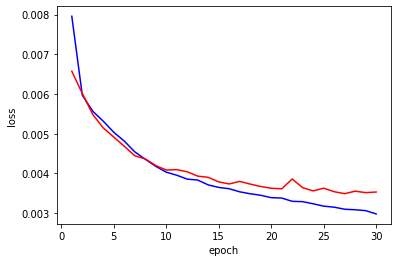

In [27]:
x = np.arange(1, 31, 1)

plt.plot(x, train_losses,'b', label='train loss')
plt.plot(x, val_losses,'r', label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

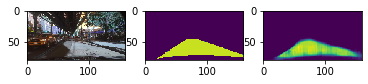

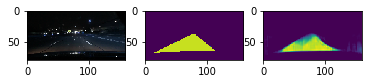

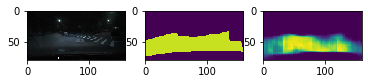

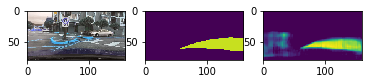

In [28]:
dataiter = iter(val_loader)
images, labels = dataiter.next()

show_img = (np.transpose(images, (0, 2, 3, 1))).numpy()
show_label = (np.transpose(labels, (0, 2, 3, 1))).numpy()

inputs, labels = images.to(device), labels.to(device)
outputs = net(inputs)
show_out = (np.transpose(outputs.detach().cpu(), (0, 2, 3, 1))).numpy()

for i in range(len(images)):
    fig = plt.figure()
    
    npimg = show_img[i]
    nplabel = show_label[i]
    nplabel = nplabel.squeeze()
    npout = show_out[i]
    npout = npout.squeeze()
    
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(npimg)
    ax2 = fig.add_subplot(1,3,2)
    ax2.imshow(nplabel)
    ax2 = fig.add_subplot(1,3,3)
    ax2.imshow(npout)
    plt.show()